# Identifying Long-Range Channels (LRCs) in MetaChat

## Brief introduction

- **Goal:** This tutorial introduces how to identify **Long-Range Channels (LRCs)** in spatial multi-omics datasets.  
- **Concept overview:**
  - *LRCs* refer to spatial region through which metabolites or signaling molecules can travel across long distances within a tissue.
  - **MetaChat** provides two complementary approaches for LRC identification:
    1. **Manual annotation** — based on prior pathological information using *Napari*-based interactive visualization.  
    2. **Marker-based clustering** — leveraging the expression patterns of specific marker genes.  

<img src="../../_static/image/identify_LRC/summary_LRCs.png" alt="summary_LRCs" width="1000"/>

We use the multi-omics dataset of mouse brain with Parkinson's disease as an example [[Marco et al., 2023](https://www.nature.com/articles/s41587-023-01937-y)].

## Manual annotation

We will give an example to show how to manually customize LRC by using Napari, an interactive tool. 
Since Napari requires an interactive interface, we recommend doing this in macOS.

### Installation

First, we need to install the squidpy package with Napari by using `pip install 'squidpy[interactive]'` in your environment.

:::{seealso}
For basic usage of Napari, please see [Squidpy document](https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_napari.html#annotate-tissue-regions-with-the-shape-layer) 
:::

### Usage

In [ ]:
# Importing packages
import os
import metachat as mc
import scanpy as sc
import squidpy as sq

In [ ]:
# Setting your work dictionary
os.chdir("/home/project/metachat_packages/")

We can download processed data from [Zenodo](https://zenodo.org/records/12629999).

In [4]:
adata = sc.read('datasets/mouse_brain_parkinson/adata_combined.h5ad')
image = adata.uns['spatial']['V11L12-109_B1']['images']['hires']
img = sq.im.ImageContainer(image, library_id='V11L12-109_B1', scale=adata.uns['spatial']['V11L12-109_B1']['scalefactors']['tissue_hires_scalef'])

:::{hint}
You can check the save information of your images in `adata.uns['spatial']`. The parameter `scale` in `sq.im.ImageContainer` is very important.
:::

Next, please activate interactive interface.

In [4]:
viewer = img.interactive(adata)

2025-10-17 14:52:28.238 python[64414:34956768] +[IMKClient subclass]: chose IMKClient_Modern
2025-10-17 14:52:28.238 python[64414:34956768] +[IMKInputSession subclass]: chose IMKInputSession_Modern
/Users/songhaoluo/mambaforge/envs/metachat_test/lib/python3.9/site-packages/squidpy/pl/_interactive/_utils.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby("clusters")[[0, 1]].apply(lambda g: list(np.median(g.values, axis=0)))
Traceback (most recent call last):
  File "/Users/songhaoluo/mambaforge/envs/metachat_test/lib/python3.9/site-packages/squidpy/pl/_interactive/_widgets.py", line 41, in <lambda>
    self.itemDoubleClicked.connect(lambda item: self._onAction((item.text(),)))
  File "/Users/songhaoluo/mambaforge/envs/metachat_test/lib/python3.9/site-packages/squidpy/pl/_interacti

We can see a interface like this:

<img src="../../_static/image/identify_LRC/LRC_1.png" alt="LRC_1" width="1000"/>

We will consider the long-range communication of cerebrospinal fluid (CSF) in this system. Click `new shapes layer`, and click `Add polygens` or `Add polygens lasso` to Select the contiguous region that you think will be the LRC. Then you change the layer name to 'LRC' and type `SHIFT + E`, you will get a observations named 'LRC_shapes'.

<img src="../../_static/image/identify_LRC/LRC_2.png" alt="LRC_2" width="1000"/>

<img src="../../_static/image/identify_LRC/LRC_3.png" alt="LRC_3" width="1000"/>

You can find the `LRC_shape` is ready in the `adata.obs['LRC_shapes']`.

In [5]:
adata

AnnData object with n_obs × n_vars = 3054 × 40235
    obs: 'in_tissue', 'array_row', 'array_col', 'tissue_type', 'LRC_shapes'
    uns: 'spatial', 'tissue_type_colors', 'LRC_shapes', 'LRC_shapes_colors'
    obsm: 'spatial'

Change the name of `adata.obs['LRC_shapes']` to `adata.obs['LRC_XXX_mannual_filtered']` for subsequent analysis, where `XXX` is the LRC name.

In [10]:
adata.obs.rename(columns={'LRC_shapes': 'LRC_CSF_manual_filtered'}, inplace=True)

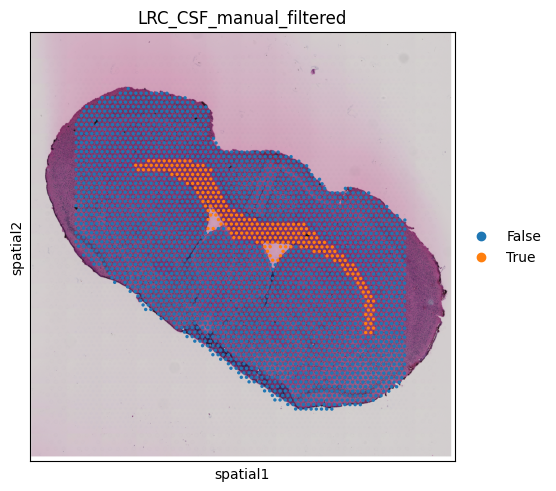

In [13]:
sq.pl.spatial_scatter(adata,
                      color = 'LRC_CSF_manual_filtered',
                      alpha = 1)

You can also use existing tissue types to generate preliminary candidate points, then perform clustering to obtain LRC.

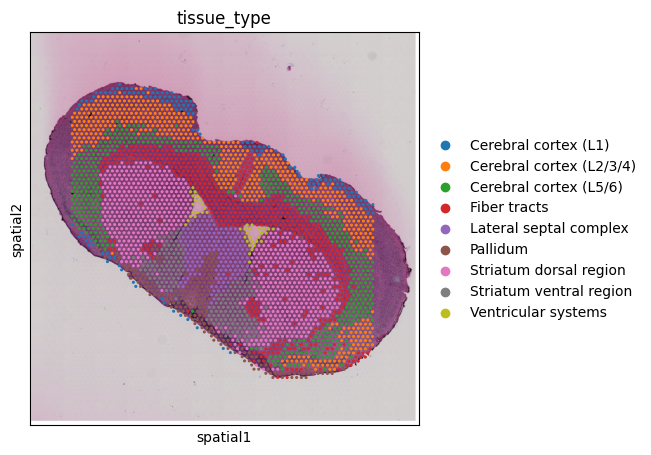

In [9]:
sq.pl.spatial_scatter(adata,
                      color = 'tissue_type',
                      alpha = 1)

We assume that the fiber tracts located near the ventricular systems may be partially permeated or influenced by CSF diffusion [[Hablitz et al., 2019](https://www.science.org/doi/10.1126/sciadv.aav5447)].

In [15]:
adata.obs['LRC_CSF_manual_unfiltered'] = ((adata.obs['tissue_type'] == 'Fiber tracts')).astype(int)

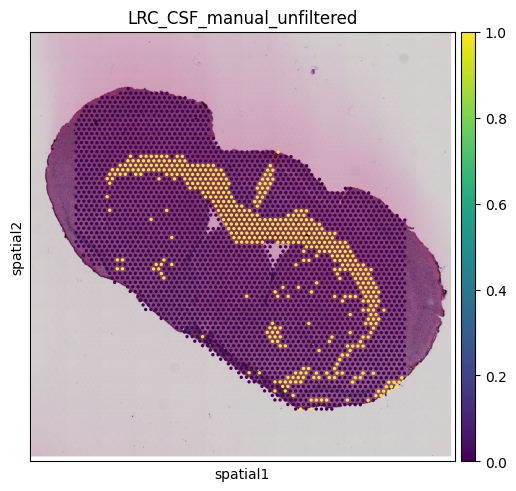

In [16]:
sq.pl.spatial_scatter(adata,
                      color = 'LRC_CSF_manual_unfiltered')

Since the unfiltered LRC still appears to contain outliers, we can use density-based clustering to filter them out [[Rodriguez et al., 2014](https://www.science.org/doi/10.1126/science.1242072)]. Function `mc.pp.LRC_cluster()` uses `adata.obs['LRC_<LRC_name>_manual_unfiltered']` to perform clustering algorithm. Of these, points that satisfy both `density > density_cutoff` and `delta > delta_cutoff` will be used as cluster centers (red solid line). And points with `density < outlier_cutoff` will be considered as outliers spots.

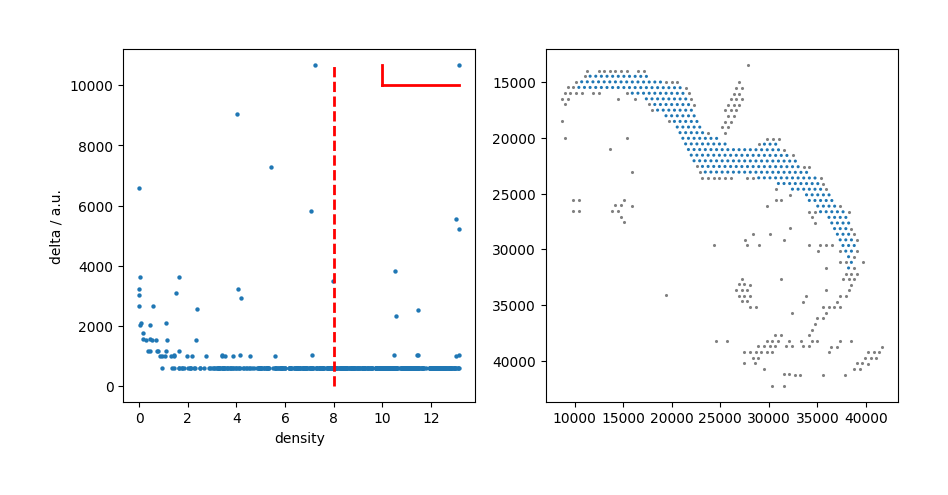

In [18]:
LRC_cluster_CSF = mc.pp.LRC_cluster(adata = adata,
                                    LRC_name = "CSF",
                                    LRC_source = "manual",
                                    density_cutoff = 10,
                                    delta_cutoff = 10000,
                                    outlier_cutoff = 8)

Then, we use `mc.pp.LRC_filtered` for assigning filtered LRC to `adata.obs['LRC_<LRC_name>_manual_filtered']`.

In [21]:
mc.pp.LRC_filtered(adata = adata,
                   LRC_name = "CSF",
                   LRC_cluster = LRC_cluster_CSF,
                   LRC_source = "manual")

Candidate points for CSF LRC are clustered and outliers are removed. LRC points are stored in 'adata.obs['LRC_CSF_manual_filtered']'.


/Users/songhaoluo/mambaforge/envs/metachat_test/lib/python3.9/site-packages/metachat/preprocessing/_identifyLRC.py:245: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs[key_filtered][adata.obs[key_filtered] == 1] = newcluster
/Users/s

In [22]:
adata

AnnData object with n_obs × n_vars = 3054 × 40235
    obs: 'in_tissue', 'array_row', 'array_col', 'tissue_type', 'LRC_CSF_manual_filtered', 'LRC_CSF_manual_unfiltered'
    uns: 'spatial', 'tissue_type_colors', 'LRC_shapes', 'LRC_shapes_colors', 'LRC_CSF_mannual_filtered_colors', 'LRC_CSF_manual_filtered_colors'
    obsm: 'spatial'

Additionally, we will incorporate the identified ventricular system spots into the analysis.

In [23]:
adata.obs['LRC_CSF_manual_filtered'] = (
    adata.obs['LRC_CSF_manual_filtered'].astype(int) | 
    (adata.obs['tissue_type'] == 'Ventricular systems').astype(int)
).astype('category')

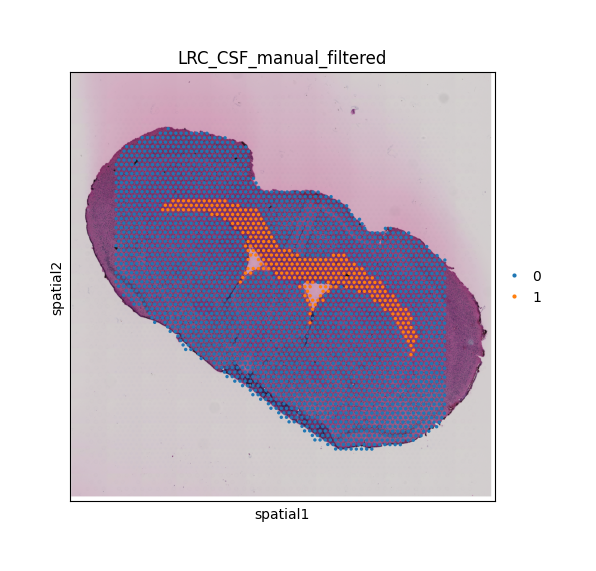

In [24]:
sq.pl.spatial_scatter(adata,
                      color = 'LRC_CSF_manual_filtered')

## Marker-based clustering annotation

When prior histologicalnatomical information is unavailable, LRCs can be alternatively identified through clustering based on gene markers. For example, CSF-associated LRCs may correspond to the expression of markers such as Gfap or other astrocytic genes, whereas blood vessel–related structures may be indicated by Mgp expression. Next, we visualize the spatial distribution of Gfap in mouse brain by using `mc.pl.plot_LRC_markers`:

<Axes: title={'center': 'Gfap'}, xlabel='spatial1', ylabel='spatial2'>

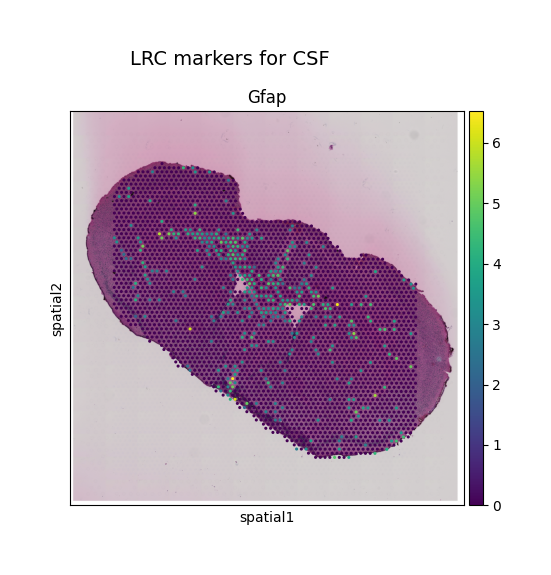

In [5]:
mc.pl.plot_LRC_markers(adata = adata,
                       LRC_name = "CSF",
                       LRC_marker_genes = ["Gfap"])

In [6]:
adata

AnnData object with n_obs × n_vars = 3054 × 40235
    obs: 'in_tissue', 'array_row', 'array_col', 'tissue_type', 'LRC_CSF_marker_Gfap'
    uns: 'spatial', 'tissue_type_colors'
    obsm: 'spatial'

We can see a clear channel near the fiber tracts. Next, we select the spots with expression above the 85% quantile as candidate spots for LRC.

In [7]:
mc.pp.LRC_unfiltered(adata = adata,
                     LRC_name = "CSF",
                     LRC_source = "marker",
                     obs_name = "LRC_CSF_marker_Gfap",
                     quantile = 85)

Cells above the 85% have been selected as candidates and stored in 'adata.obs['LRC_CSF_marker_unfiltered']'.


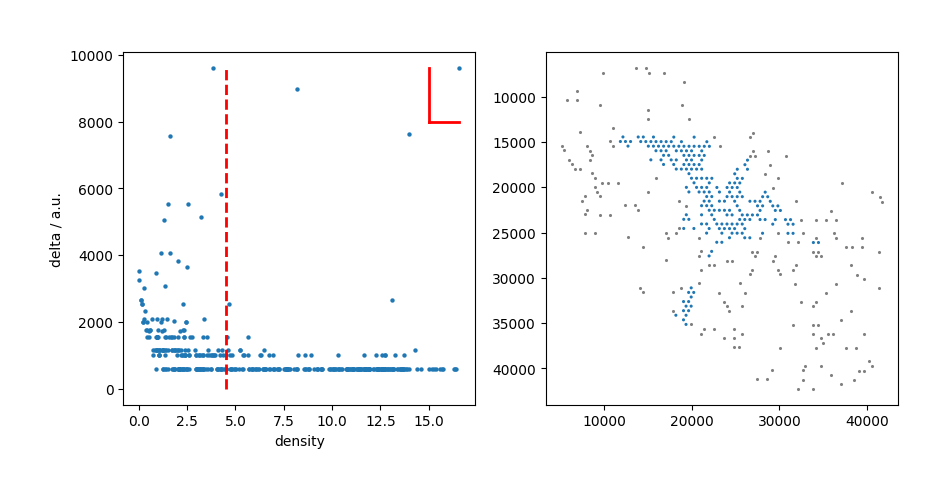

In [11]:
LRC_cluster_CSF = mc.pp.LRC_cluster(adata = adata,
                                    LRC_name = "CSF",
                                    LRC_source = "marker",
                                    density_cutoff = 15,
                                    delta_cutoff = 8000,
                                    outlier_cutoff = 4.5)

:::{tip}
This step allows you to keep adjusting the parameters (`density_cutoff`, `delta_cutoff` and `outlier_cutoff`) to get the best visual effect.
:::

In [14]:
mc.pp.LRC_filtered(adata = adata,
                   LRC_name = "CSF",
                   LRC_cluster = LRC_cluster_CSF,
                   LRC_source = "marker")

Candidate points for CSF LRC are clustered and outliers are removed. LRC points are stored in 'adata.obs['LRC_CSF_marker_filtered']'.


/Users/songhaoluo/Library/CloudStorage/OneDrive-UCIrvine/2_Unpublished_work/1_Metabolite_Chat/4_Codes/tutorials/MetaChat-main/metachat_new/preprocessing/_identifyLRC.py:245: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.obs[key_filtere

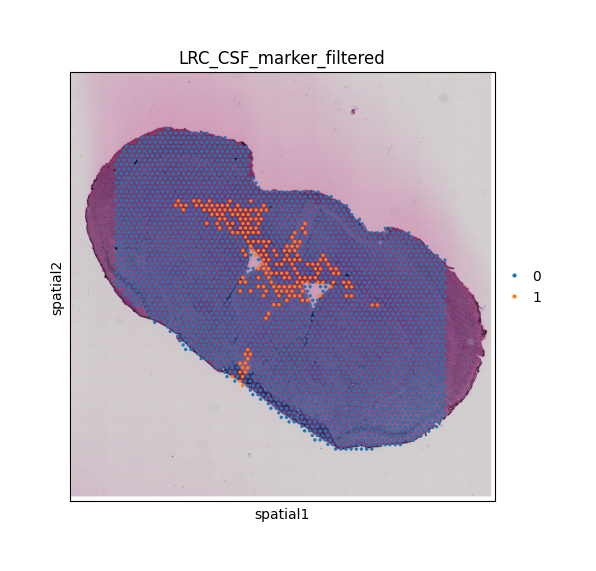

In [15]:
sq.pl.spatial_scatter(adata,
                      color = 'LRC_CSF_marker_filtered')